In [106]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
import numpy.random as rnd
from neurodynex3.tools import plot_tools
import numpy
import matplotlib.pyplot as plt
from math import floor
import time
import pickle

b2.defaultclock.dt = 0.10 * b2.ms

from brian2 import *

In [107]:
def nmda_by_x(x_rate, w_pos):
    
    start_scope()
    #w_pos = 1.9
    N_Excit=384
    N_Inhib=96
    weight_scaling_factor=5.33
    t_stimulus_start=100 * b2.ms
    t_stimulus_duration=9999 * b2.ms
    coherence_level=0.
    stimulus_update_interval=30 * b2.ms
    mu0_mean_stimulus_Hz=250.
    stimulus_std_Hz=20.
    N_extern=1000
    firing_rate_extern=9.8 * b2.Hz
    f_Subpop_size=0.25  # .15 in publication [1]                     
    max_sim_time=1000. * b2.ms 
    stop_condition_rate=None

    monitored_subset_size=512, 
    E_leak_excit = -70.0 * b2.mV

    print("simulating {} neurons. Start: {}".format(N_Excit + N_Inhib, time.ctime()))
    t_stimulus_end = t_stimulus_start + t_stimulus_duration

    N_Group_A = int(N_Excit * f_Subpop_size)  # size of the excitatory subpopulation sensitive to stimulus A
    N_Group_B = N_Group_A  # size of the excitatory subpopulation sensitive to stimulus B
    N_Group_Z = N_Excit - N_Group_A - N_Group_B  # (1-2f)Ne excitatory neurons do not respond to either stimulus.

    Cm_excit = 0.5 * b2.nF  # membrane capacitance of excitatory neurons
    G_leak_excit = 25.0 * b2.nS  # leak conductance
    E_leak_excit = -70.0 * b2.mV  # reversal potential   #######################################################
    v_spike_thr_excit = -50.0 * b2.mV  # spike condition
    v_reset_excit = -60.0 * b2.mV  # reset voltage after spike
    t_abs_refract_excit = 2. * b2.ms  # absolute refractory period

    # specify the inhibitory interneurons:
    # N_Inhib = 200
    Cm_inhib = 0.2 * b2.nF
    G_leak_inhib = 20.0 * b2.nS
    E_leak_inhib = -90.0 * b2.mV
    v_spike_thr_inhib = -50.0 * b2.mV
    v_reset_inhib = -60.0 * b2.mV
    t_abs_refract_inhib = 1.0 * b2.ms

    # specify the AMPA synapses
    E_AMPA = 0.0 * b2.mV
    tau_AMPA = 2.5 * b2.ms

    # specify the GABA synapses
    E_GABA = -70.0 * b2.mV
    tau_GABA = 5.0 * b2.ms

    # specify the NMDA synapses
    E_NMDA = 0.0 * b2.mV
    tau_NMDA_s = 100.0 * b2.ms
    tau_NMDA_x = 2. * b2.ms
    alpha_NMDA = 0.5 * b2.kHz

    # projections from the external population
    g_AMPA_extern2inhib = 1.62 * b2.nS
    g_AMPA_extern2excit = 2.1 * b2.nS

    # projectsions from the inhibitory populations
    g_GABA_inhib2inhib = weight_scaling_factor * 1.25 * b2.nS
    g_GABA_inhib2excit = weight_scaling_factor * 1.60 * b2.nS

    # projections from the excitatory population
    g_AMPA_excit2excit = weight_scaling_factor * 0.012 * b2.nS
    g_AMPA_excit2inhib = weight_scaling_factor * 0.015 * b2.nS
    g_NMDA_excit2excit = weight_scaling_factor * 0.040 * b2.nS
    g_NMDA_excit2inhib = weight_scaling_factor * 0.045 * b2.nS  # stronger projection to inhib.

    # weights and "adjusted" weights.
    w_neg = 1. - f_Subpop_size * (w_pos - 1.) / (1. - f_Subpop_size)
    # We use the same postsyn AMPA and NMDA conductances. Adjust the weights coming from different sources:
    w_ext2inhib = g_AMPA_extern2inhib / g_AMPA_excit2inhib
    w_ext2excit = g_AMPA_extern2excit / g_AMPA_excit2excit
    # other weights are 1
    # print("w_neg={}, w_ext2inhib={}, w_ext2excit={}".format(w_neg, w_ext2inhib, w_ext2excit))A
    # Define the inhibitory population



    excit_lif_dynamics = """
            s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
            dv/dt = (
            - G_leak_excit * (v-E_leak_excit)
            - g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
            - g_GABA_inhib2excit * s_GABA * (v-E_GABA)
            - g_NMDA_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
            )/Cm_excit : volt (unless refractory)
            ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
            ds_GABA/dt = -s_GABA/tau_GABA : 1
            ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
            dx/dt = -x/tau_NMDA_x : 1
        """
    
    excit_lif_dynamics_nmda = """
            s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
            dv/dt = (
            - G_leak_excit * (v-E_leak_excit)
            - g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
            - g_GABA_inhib2excit * s_GABA * (v-E_GABA)
            - g_NMDA_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
            )/Cm_excit : volt (unless refractory)
            ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
            ds_GABA/dt = -s_GABA/tau_GABA : 1
            ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
            dx/dt = -x/tau_NMDA_x : 1
        """


    one_neuron = NeuronGroup(1, model=excit_lif_dynamics_nmda,
                            threshold="v>v_spike_thr_excit", reset="v=v_reset_excit",
                            refractory=t_abs_refract_excit, method="rk2")

    one_neuron.v = rnd.uniform(E_leak_excit / b2.mV, high=E_leak_excit / b2.mV + 5., size=one_neuron.N) * b2.mV




    # network parameters
    N_E = 1000
    gamma = 0.25
    N_I = round(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.1
    C_E = epsilon * N_E
    C_ext = C_E

    # neuron parameters
    tau = 10 * ms
    theta = 1 * mV
    V_r = 0 * mV
    tau_rp = 2 * ms

    # synapse parameters
    J = 0.1 * mV
    D = 1.5 * ms
    nu_ext = 10 *Hz
    # external stimulus
    nu_thr = theta / (J * C_E * tau)

    defaultclock.dt = 0.1 * ms

    Poisson_NE = 1000
    g = 1

    #w_pos= 1.9



    # with and without NMDA 와 비교하기 
    exc_poisson_input = PoissonInput(
            target=one_neuron, target_var="s_AMPA", N=N_E, rate=1*nu_ext, weight= w_ext2excit)       

    inh_poisson_input = PoissonInput(
            target=one_neuron, target_var="s_GABA", N=N_I, rate=1*nu_ext, weight= w_ext2inhib)

    nmda_poisson_input = PoissonInput(
            target=one_neuron, target_var="x", N=1, rate= x_rate*Hz, weight= 1 )

    #NDMA input 
    sNMDA_A_total = []

    @network_operation()
    def update_nmda_sum():
            sum_sNMDA_A = 300*sum(one_neuron.s_NMDA)

            #sum_sNMDA_A = 100

            # note the _ at the end of s_NMDA_total_ disables unit checking
            one_neuron.s_NMDA_total_ = (w_pos * sum_sNMDA_A)  ## 자기 자신의 nmda input 만을 받는다. 
            sNMDA_A_total.append(sum_sNMDA_A)


    # set a self-recurrent synapse to introduce a delay when updating the intermediate
    # gating variable x

    syn_x_A2A = Synapses(one_neuron, one_neuron, on_pre="x += 1.", delay=0.5 * b2.ms)
    syn_x_A2A.connect(j="i")

    rmp_monitor = StateMonitor(one_neuron, 'v', record = 0)

    x_monitor = StateMonitor(one_neuron, 'x', record = 0)
    s_monitor = StateMonitor(one_neuron, 's_NMDA', record = 0)


    rmp_in_mV = 1000*(rmp_monitor.v[0])

    rmp_in_mV = 1000*(rmp_monitor.v[0])




    run(1200*ms, report='text')

    time_in_ms = (rmp_monitor.t/ms)/1000
    rmp_in_mV = (rmp_monitor.v[0])/b2.mV
    
    
    return time_in_ms, rmp_in_mV   # the unit is ms and mV 

In [108]:
a = nmda_by_x(100, 1.5)
num_time = len(a[0])
num_trial = 20
rmp_mat = numpy.zeros([num_trial, num_time])
rmp_mat[:10]


WARNING    "i" is an internal variable of group "synapses", but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


simulating 480 neurons. Start: Thu Dec 15 16:41:46 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [109]:
for trial_idx in range((num_trial)):
    result = nmda_by_x(100, 1.5)
    rmp = result[1]
    rmp_mat[trial_idx,:] = rmp
    
    

simulating 480 neurons. Start: Thu Dec 15 16:41:48 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:41:51 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:41:53 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:41:55 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:41:57 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:41:59 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:42:01 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Sta

In [110]:
rmp_mat_1p5 = rmp_mat

rmp_mean_1p5 = numpy.mean(rmp_mat, axis=0)
rmp_sem_1p5 = numpy.std(rmp_mat, axis=0)/numpy.sqrt(num_trial)

In [111]:
rmp_mat = numpy.zeros([num_trial, num_time])


for trial_idx in range(num_trial):
    result = nmda_by_x(100, 2.2)
    rmp = result[1]
    rmp_mat[trial_idx,:] = rmp
    
    
    

simulating 480 neurons. Start: Thu Dec 15 16:42:32 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:42:34 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:42:36 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:42:38 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:42:40 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:42:43 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Start: Thu Dec 15 16:42:45 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 2s
simulating 480 neurons. Sta

In [112]:
time = result[0]


In [113]:
rmp_mean = numpy.mean(rmp_mat, axis=0)
rmp_sem = numpy.std(rmp_mat, axis=0)/numpy.sqrt(num_trial)

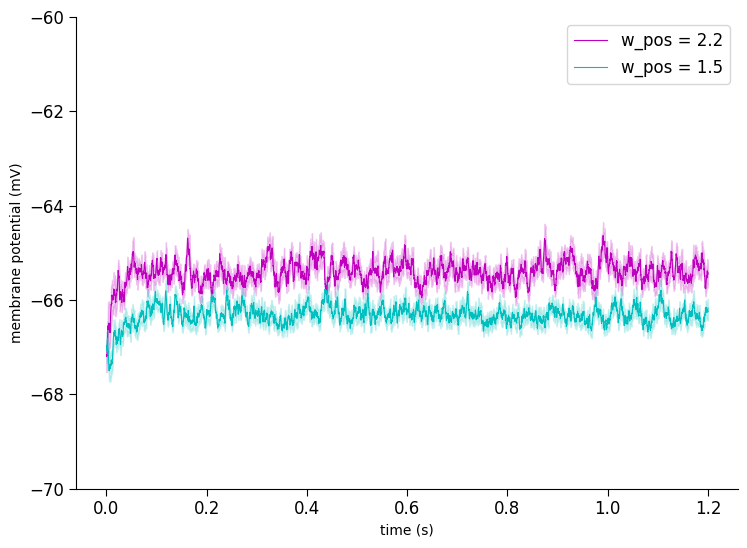

In [114]:
fig, ax = plt.subplots(1,figsize=(8, 6))

ax.plot(result[0], rmp_mean, 'm-', label='w_pos = 2.2', linewidth=0.8) 
ax.fill_between(time, rmp_mean - rmp_sem, rmp_mean + rmp_sem, color='m', alpha=0.2)

ax.plot(result[0], rmp_mean_1p5, 'c-', label='w_pos = 1.5', linewidth=0.8) 
ax.fill_between(time, rmp_mean_1p5 - rmp_sem_1p5, rmp_mean_1p5 + rmp_sem_1p5, color='c', alpha=0.2)



ax.set_ylim([-70, -60])

ax.legend()


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



ax.set_xlabel('time (s)')
ax.set_ylabel('membrane potential (mV)')
plt.rcParams.update({'font.size': 24})
plt.savefig("figure6_one_cell_by_w_pos_nmda_input.svg", transparent=True)    



plt.show()

In [115]:
rmp_mat

array([[-65.40340867, -65.42633417, -65.4222855 , ..., -65.42073141,
        -65.415734  , -65.36603499],
       [-69.8536808 , -69.85441056, -69.82646385, ..., -65.6084591 ,
        -65.54670382, -65.43715514],
       [-66.51487295, -66.53225502, -66.52223776, ..., -64.66655167,
        -64.59144421, -64.48495383],
       ...,
       [-66.71286017, -66.72925478, -66.80111542, ..., -66.38819898,
        -66.47490564, -66.45695631],
       [-65.0539843 , -65.07865255, -65.07648029, ..., -64.10412089,
        -64.13976325, -64.13350035],
       [-65.77722055, -65.79828166, -65.93322117, ..., -65.36629855,
        -65.29669203, -65.24425181]])

In [116]:
rmp_sem_1p5

array([0.29688657, 0.29540585, 0.29185094, ..., 0.19068979, 0.19401741,
       0.19888545])

In [117]:
rmp_mat_1p5

array([[-67.9440371 , -67.95429122, -67.9087162 , ..., -67.46539544,
        -67.46548127, -67.46081189],
       [-69.63153262, -69.63337035, -69.60661658, ..., -64.96768553,
        -64.88221102, -64.81324082],
       [-69.06808347, -69.07273141, -69.07735616, ..., -66.17492084,
        -66.1512404 , -66.30963003],
       ...,
       [-65.97737751, -65.99744034, -65.96322719, ..., -66.98983315,
        -67.13150595, -67.15380741],
       [-66.30674057, -66.32516071, -66.31626112, ..., -67.62746487,
        -67.61678162, -67.60915547],
       [-69.08835313, -69.09289997, -69.06906308, ..., -65.81797889,
        -65.75958803, -65.69103724]])

In [118]:
ind_ave_2p2 = rmp_mat.mean(axis =1)

In [119]:
ind_ave_1p5 = rmp_mat_1p5.mean(axis =1)

In [120]:
import scipy.stats

scipy.stats.ttest_ind(ind_ave_1p5, ind_ave_2p2, equal_var=False)

Ttest_indResult(statistic=-36.412482130888336, pvalue=3.129568242957458e-29)

In [121]:
ind_ave_2p2.mean()

-65.41231310269544

In [122]:
ind_ave_1p5.mean()

-66.32377746410693

In [123]:
ave_points_2p2 = rmp_mat.mean(axis =1)

In [124]:
ave_points_1p5 = rmp_mat_1p5.mean(axis =1)

In [125]:
mean_1p5 = ave_points_1p5.mean()

In [126]:
std_1p5 = ave_points_1p5.std()

In [127]:
mean_2p2 = ave_points_2p2.mean()

std_2p2 = ave_points_2p2.std()

In [128]:
error_bars = [std_1p5, std_2p2]

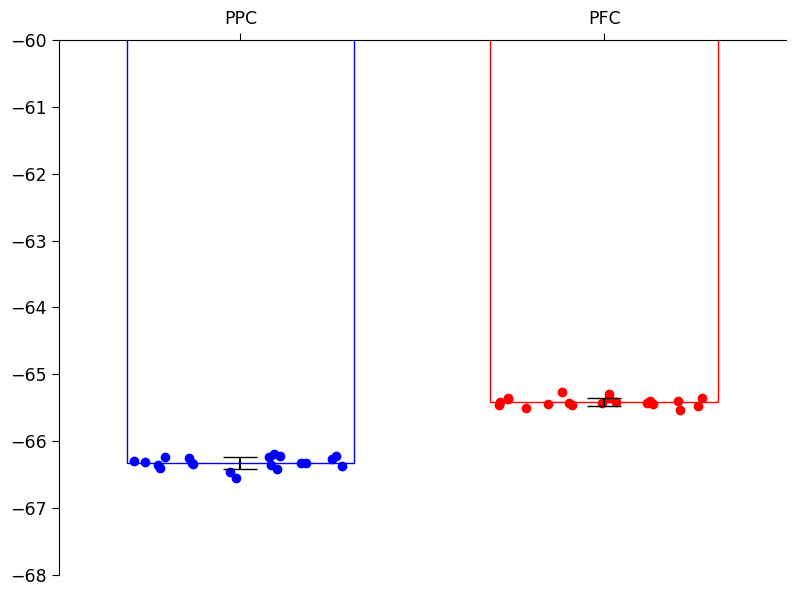

In [136]:
import matplotlib.pyplot as plt
#np.random.seed(123)

plt.style.use('https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle')


w = 0.25    # bar width
x = [0.2, 0.6] # x-coordinates of your bars
colors = [(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors
mean_bars = [mean_1p5,       # data series
    mean_2p2]

y = ([ave_points_1p5,       # data series
    ave_points_2p2])




fig, ax = plt.subplots()

ax.bar(x,
       height= mean_bars,
       yerr=error_bars,    # error bars
       capsize=12, # error bar cap width in points
       width=w,    # bar width
       tick_label=["PPC", "PFC"],
       color=(0,0,0,0),  # face color transparent
       edgecolor=colors,
       #ecolor=colors,    # error bar colors; setting this raises an error for whatever reason.
       )
ax.xaxis.tick_top()
#axes.spines.top = True

ax.spines.top.set_visible(True)
ax.spines['bottom'].set_visible(False)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title 


for i in range(len(x)):
    # distribute scatter randomly across whole width of bar
    ax.scatter(x[i] + np.random.random(y[i].size) * w - w / 2, y[i], color=colors[i])
    
plt.xlim([0, 0.8])
#plt.ylim([-68.5, -67.5])

plt.ylim([-68, -60])



plt.show()

In [130]:
scipy.stats.ttest_ind(ave_points_1p5, ave_points_2p2, equal_var=False)

Ttest_indResult(statistic=-36.412482130888336, pvalue=3.129568242957458e-29)

In [137]:
ave_points_2p2

array([-65.44951562, -65.3545058 , -65.29430983, -65.47869534,
       -65.39936147, -65.45874845, -65.41805274, -65.39462   ,
       -65.53579773, -65.46167082, -65.42881084, -65.36671053,
       -65.50966203, -65.41448685, -65.35465916, -65.42756316,
       -65.437742  , -65.27098756, -65.36157632, -65.4287858 ])

In [138]:
ave_points_2p2 - ave_points_1p5

array([0.89505388, 1.1128617 , 1.00723285, 0.84852578, 0.99998377,
       0.95883858, 0.90527559, 0.92500182, 0.65635886, 0.77095107,
       0.84184184, 1.19027358, 0.84920637, 0.88999255, 0.86791348,
       0.82821998, 0.91577684, 0.95164172, 1.00560347, 0.80873348])

In [139]:
a = [0.15108195, 0.06464025, 0.10755381, 0.14588016, 0.14590874,
       0.12137242, 0.19113839, 0.19032228, 0.09256572, 0.25674468,
       0.14814917, 0.17152546, 0.00872239, 0.12424605, 0.10436863,
       0.02164696, 0.15174255, 0.06077489, 0.17077517, 0.07827844]

In [140]:
b= ave_points_2p2 - ave_points_1p5

In [145]:
a = numpy.array(a)

In [148]:
b_mean = b.mean()

In [149]:
a_mean = a.mean()

In [150]:
a_std = a.std()

In [151]:
b_std = b.std()

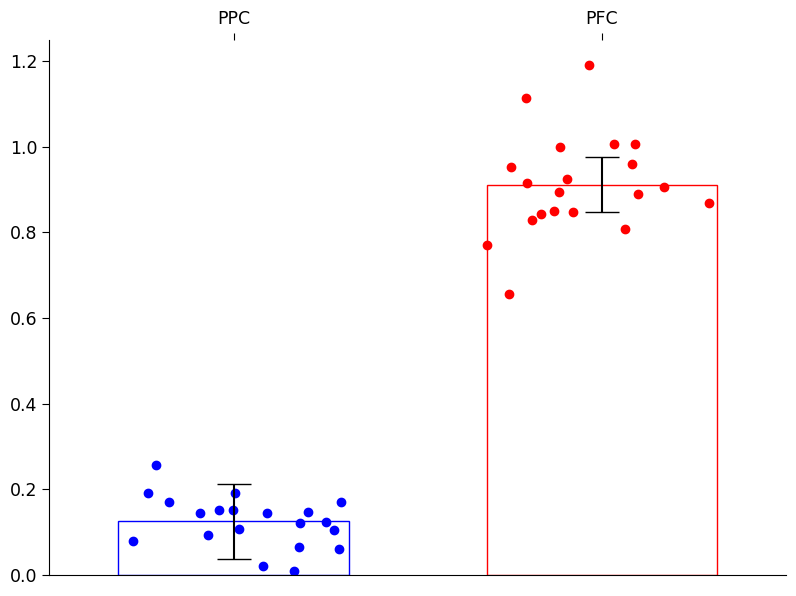

In [154]:
import matplotlib.pyplot as plt
#np.random.seed(123)

plt.style.use('https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle')


w = 0.25    # bar width
x = [0.2, 0.6] # x-coordinates of your bars
colors = [(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors
mean_bars = [a_mean,       # data series
    b_mean]

y = ([a,       # data series
    b])

error = [a_std, b_std]



fig, ax = plt.subplots()

ax.bar(x,
       height= mean_bars,
       yerr=error_bars,    # error bars
       capsize=12, # error bar cap width in points
       width=w,    # bar width
       tick_label=["PPC", "PFC"],
       color=(0,0,0,0),  # face color transparent
       edgecolor=colors,
       #ecolor=colors,    # error bar colors; setting this raises an error for whatever reason.
       )
ax.xaxis.tick_top()
#axes.spines.top = True

ax.spines.top.set_visible(False)
ax.spines['bottom'].set_visible(True)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title 


for i in range(len(x)):
    # distribute scatter randomly across whole width of bar
    ax.scatter(x[i] + np.random.random(y[i].size) * w - w / 2, y[i], color=colors[i])
    
plt.xlim([0, 0.8])
#plt.ylim([-68.5, -67.5])

#lt.ylim([-68, -60])



plt.show()